In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


In [2]:
# Directory
train_data_dir = '/Users/rishabhsolanki/Desktop/Machine learning/ios/Data/train_data'
# Image dimensions
img_width, img_height = 150, 150
batch_size = 5  # Adjust this as per the computation capacity of your system


In [3]:
# Initialize ImageDataGenerator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.2  # Using 20% of the data for validation
)

# Configure the train_generator for training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Specify this subset for training data
)

# Configure the val_generator for validation data
val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Specify this subset for validation data
)

Found 51 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
# Model definition
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [5]:
from keras.optimizers import Adam  # or any other optimizer you want to use

# Define the learning rate
learning_rate = 0.01

# Instantiate the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Now, use this optimizer while compiling the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [6]:
# Train the CNN
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/20
10/10 [==============================] - 2s 122ms/step - loss: 3.2481 - accuracy: 0.5000 - val_loss: 0.6873 - val_accuracy: 0.6000
Epoch 2/20
10/10 [==============================] - 1s 96ms/step - loss: 0.6939 - accuracy: 0.4565 - val_loss: 0.6947 - val_accuracy: 0.4500
Epoch 3/20
10/10 [==============================] - 1s 95ms/step - loss: 0.6974 - accuracy: 0.3261 - val_loss: 0.6924 - val_accuracy: 0.5500
Epoch 4/20
10/10 [==============================] - 1s 108ms/step - loss: 0.6926 - accuracy: 0.5652 - val_loss: 0.6918 - val_accuracy: 0.5500
Epoch 5/20
10/10 [==============================] - 1s 108ms/step - loss: 0.6911 - accuracy: 0.5652 - val_loss: 0.6908 - val_accuracy: 0.5500
Epoch 6/20
10/10 [==============================] - 1s 104ms/step - loss: 0.6921 - accuracy: 0.5217 - val_loss: 0.6904 - val_accuracy: 0.5500
Epoch 7/20
10/10 [==============================] - 1s 105ms/step - loss: 0.6921 - accuracy: 0.5400 - val_loss: 0.6910 - val_accuracy: 0.5500
Epoch 8/

In [7]:
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential, Model

In [8]:
# Extract features from the training and validation data
feature_model = Model(inputs=model.input, outputs=model.layers[-4].output)

In [9]:
# Modify the extraction function to return images too
def extract_features_and_labels(generator, feature_model):
    features_list = []
    labels_list = []
    images_list = []

    # Resetting generator to start from the beginning
    generator.reset()
    for batch in range(generator.samples // generator.batch_size):
        images, labels = next(generator)
        features = feature_model.predict(images)
        features_list.append(features)
        labels_list.append(labels)
        images_list.append(images)

    return np.vstack(features_list), np.hstack(labels_list), np.vstack(images_list)


In [23]:
train_features, train_labels, train_images = extract_features_and_labels(train_generator, feature_model)
val_features, val_labels, val_images = extract_features_and_labels(val_generator, feature_model)


1/1 [==============================] - 0s 16ms/step


In [24]:
# Train the RandomForest on the features
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_features, train_labels)

RandomForestClassifier()

In [25]:
# Predict using CNN on original images
cnn_predictions = model.predict(val_images)  # Use val_images instead of val_features


1/1 [==============================] - 0s 40ms/step


In [26]:
# Predict using RandomForest on extracted features
rf_probabilities = clf.predict_proba(val_features)[:, 1]  # get the probability for class 1


In [27]:
# Combining predictions
final_predictions = 0.5 * cnn_predictions.flatten() + 0.5 * rf_probabilities
final_class_predictions = [1 if pred > 0.5 else 0 for pred in final_predictions]


In [28]:
# Print the results
print("True Labels:", val_labels)
print("CNN Predictions:", cnn_predictions.flatten())
print("RandomForest Predictions:", rf_probabilities)
print("Combined Predictions:", final_class_predictions)

True Labels: [0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
CNN Predictions: [0.4547172 0.4547172 0.4547172 0.4547172 0.4547172 0.4547172 0.4547172
 0.4547172 0.4547172 0.4547172 0.4547172 0.4547172 0.4547172 0.4547172
 0.4547172 0.4547172 0.4547172 0.4547172 0.4547172 0.4547172]
RandomForest Predictions: [0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368
 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368 0.4368]
Combined Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


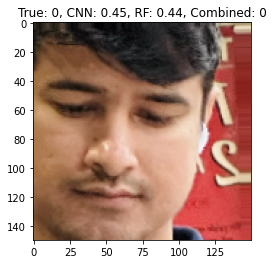

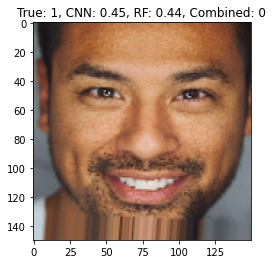

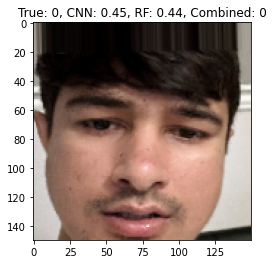

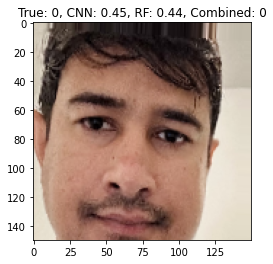

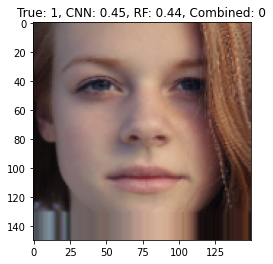

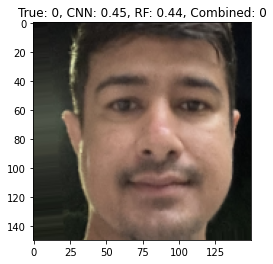

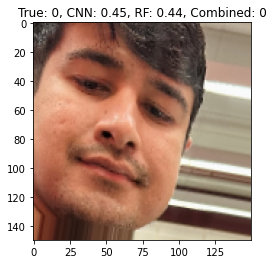

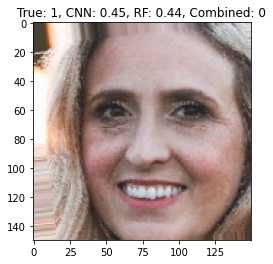

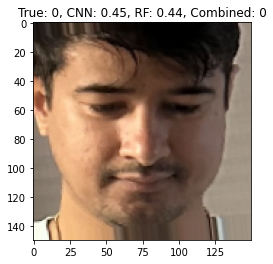

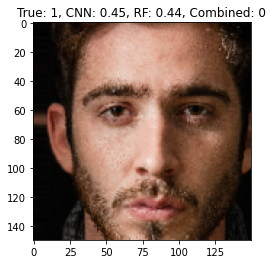

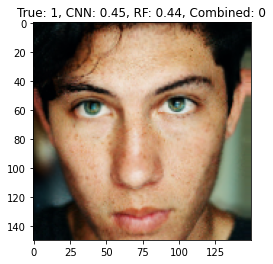

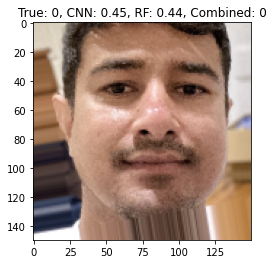

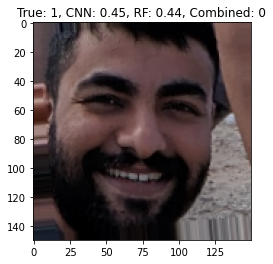

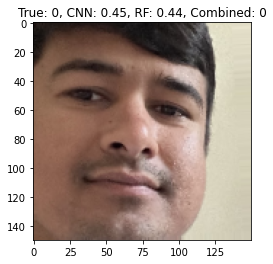

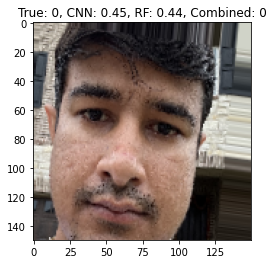

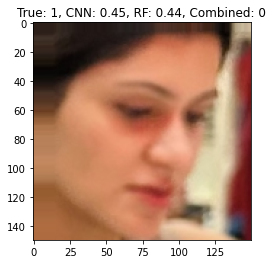

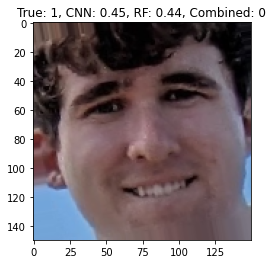

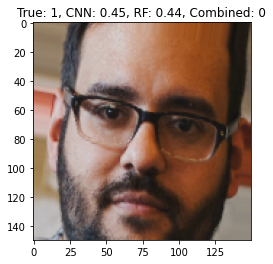

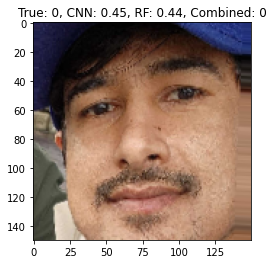

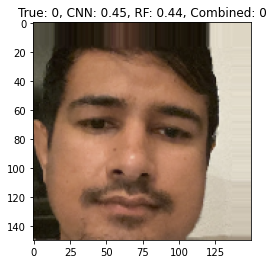

In [29]:
import matplotlib.pyplot as plt

# Visualization
for i in range(len(val_images)):
    plt.imshow(val_images[i])
    plt.title(f"True: {int(val_labels[i])}, CNN: {cnn_predictions[i][0]:.2f}, RF: {rf_probabilities[i]:.2f}, Combined: {final_class_predictions[i]}")
    plt.show()

In [17]:
# CoreML Conversion
import coremltools as ct
from coremltools.models.neural_network import NeuralNetworkBuilder, SgdParams

In [18]:
# CoreML Conversion
input_shape = (1, 150, 150, 3)
input_shape_spec = ct.Shape(shape=input_shape)
input_spec = ct.ImageType(shape=input_shape_spec, bias=[0, 0, 0], scale=1/255.0)

In [19]:
# Convert to CoreML
coreml_model = ct.convert(model, inputs=[input_spec], source='tensorflow')


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 57/57 [00:00<00:00, 86.38 ops/s]


In [21]:
layer_names1 = [layer.name for layer in coreml_model.get_spec().neuralNetwork.layers]

for name in layer_names1:
    print(name)


sequential/conv2d/BiasAdd
sequential/activation/Relu
max_pool_0
sequential/conv2d_1/BiasAdd
sequential/activation_1/Relu
max_pool_1
sequential/conv2d_2/BiasAdd
sequential/activation_2/Relu
max_pool_2
transpose_11
sequential/flatten/Reshape
sequential/dense/BiasAdd
sequential/activation_3/Relu
sequential/dense_1/BiasAdd
sequential/activation_4/Sigmoid


In [22]:
# let's inspect the last few layers of this model
spec = coreml_model.get_spec()
builder = ct.models.neural_network.NeuralNetworkBuilder(spec=spec)
builder.inspect_layers(last=3)

[Id: 14], Name: sequential/activation_4/Sigmoid (Type: activation)
          Updatable: False
          Input blobs: ['sequential/dense_1/BiasAdd']
          Output blobs: ['Identity']
[Id: 13], Name: sequential/dense_1/BiasAdd (Type: innerProduct)
          Updatable: False
          Input blobs: ['sequential/activation_3/Relu']
          Output blobs: ['sequential/dense_1/BiasAdd']
[Id: 12], Name: sequential/activation_3/Relu (Type: activation)
          Updatable: False
          Input blobs: ['sequential/dense/BiasAdd']
          Output blobs: ['sequential/activation_3/Relu']
